## Installation du cache

In [1]:
pip install diskcache

## Défintion des fonctions pour les requetes

In [2]:
import requests
import time
import diskcache as dc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import math

# Initialiser le cache
cache = dc.Cache('cache_dir')

def get_article_metadata(doi, min_year=None):
    """
    Récupère les métadonnées d'un article donné à partir de l'API Crossref.
    """
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()['message']

        # Gérer les cas où le titre est absent ou vide
        title = data.get('title', ['Unknown Title'])
        title = title[0] if title else 'Unknown Title'

        authors = [
            {
                "given": author.get("given", ""),
                "family": author.get("family", ""),
            }
            for author in data.get("author", [])
        ]

        journal = data.get('container-title', ['Unknown Journal'])[0] if data.get('container-title') else data.get('publisher', '')
        year = data.get('published-print', {}).get('date-parts', [[None]])[0][0]
        if year is None:
            return None

        # Vérification de l'année minimale
        if min_year and isinstance(year, int) and year < min_year:
            #print(f"Article rejeté (publié avant {min_year}) : {doi}")
            return None

        return {
            "doi": doi,
            "title": title,
            "authors": authors,
            "journal": journal,
            "year": year,
        }
    else:
        print(f"Erreur : Impossible de récupérer les données pour le DOI {doi}")
        return None

def get_related_dois(doi, min_year, direction="references"):
    """
    Récupère les articles cités ou citant un article donné via OpenCitations.
    """
    base_url = "https://opencitations.net/index/api/v1/" + ("citations/" if direction == "citations" else "references/")
    url = f"{base_url}{doi}"
    response = requests.get(url)
    if response.status_code == 200:
        return [item.get('cited', '') if direction == "references" else item.get('citing', '') for item in response.json()]
    else:
        print(f"Erreur lors de la récupération des {direction} pour le DOI {doi}: {response.status_code}")
        return []

def get_article_metadata_cached(doi, min_year):
    if doi in cache:
        print(f"Article déjà interrogé {doi}")  # Afficher que l'article est récupéré depuis le cache
        return cache[doi]
    data = get_article_metadata(doi, min_year)
    if data:
        print(f"Nouvel article {doi}")  # Afficher que l'article est récupéré via l'API
        cache[doi] = data
    return data

def get_related_dois_cached(doi, min_year, direction="references"):
    cache_key = f"{doi}_{direction}"
    if cache_key in cache:
        return cache[cache_key]
    related_dois = get_related_dois(doi, min_year, direction)
    cache[cache_key] = related_dois
    return related_dois


def process_article(doi, depth=3, min_year=1965):
    """
    Récupère les métadonnées et construit un graphe avec les articles liés.
    Exclut les articles sans année ou sans nom de journal.
    Utilise une approche itérative pour éviter la récursion.
    """
    G = nx.DiGraph()

    # Utilisation d'une pile pour gérer les nœuds à traiter avec leur profondeur
    stack = [(doi, 0, True)]  # (doi, current_depth, is_initial_article)

    # Tant qu'il y a des nœuds à traiter dans la pile
    while stack:
        # Récupérer le nœud actuel et sa profondeur
        current_doi, current_depth, is_initial_article = stack.pop()

        # Vérifier si la profondeur a été atteinte
        if current_depth > depth:
            continue

        # Récupérer les métadonnées avec mise en cache
        article_data = get_article_metadata_cached(current_doi, min_year)

        if article_data:
          # Assurez-vous que les données de l'article sont valides
          title = article_data.get("title", "")
          if title and article_data.get("journal"):
              # Ajouter le nœud au graphe avec les métadonnées
              print(f"Ajout du nœud : {current_doi}")
              if current_doi not in G.nodes:
                  G.add_node(current_doi)

              # Ajouter les métadonnées au nœud
              G.nodes[current_doi]["title"] = article_data.get("title", "Unknown Title")
              G.nodes[current_doi]["authors"] = article_data.get("authors", [])
              G.nodes[current_doi]["year"] = article_data.get("year", "Unknown Year")
              G.nodes[current_doi]["journal"] = article_data.get("journal", "Unknown Journal")

          # Ajouter les articles référencés et cités
          if is_initial_article:
              # Pour l'article de départ, on ajoute à la pile les DOIs citants ET référencés
              referenced_dois = get_related_dois_cached(current_doi, min_year, direction="references")
              citing_dois = get_related_dois_cached(current_doi, min_year, direction="citations")

              # Ajouter les arêtes (relations entre les nœuds)
              for ref_doi in referenced_dois:
                  if ref_doi and ref_doi not in G.nodes:  # Vérifier l'existence avant l'ajout
                      G.add_edge(current_doi, ref_doi)
                      stack.append((ref_doi, current_depth + 1, False))  # False, ce n'est plus l'article initial

              for cite_doi in citing_dois:
                  if cite_doi and cite_doi not in G.nodes:  # Vérifier l'existence avant l'ajout
                      G.add_edge(cite_doi, current_doi)
                      stack.append((cite_doi, current_depth + 1, False))  # False, ce n'est plus l'article initial

          else:
              # Pour les articles référencés ou citants, on ajoute seulement les articles référencés
              referenced_dois = get_related_dois_cached(current_doi, min_year, direction="references")

              for ref_doi in referenced_dois:
                  if ref_doi and ref_doi not in G.nodes:  # Vérifier l'existence avant l'ajout
                      G.add_edge(current_doi, ref_doi)
                      stack.append((ref_doi, current_depth + 1, False))  # False, ce n'est plus l'article initial

    return G


In [3]:
def visualize_graph(graph, root_doi, max_generation=2, show_labels=True, min_year_graph=1990):
    """
    Affiche le graphe avec :
    - des couleurs pour chaque année de publication,
    - une réduction des nœuds et connexions pour une meilleure lisibilité,
    - des labels pour les nœuds les plus significatifs.

    Args:
    - graph: Le graphe NetworkX représentant les articles et leurs relations.
    - root_doi: DOI de l'article central, qui sera mis en évidence.
    - max_generation: Nombre de générations à inclure dans le graphe (positives et négatives).
    - show_labels: Booléen pour activer ou désactiver l'affichage des labels des nœuds.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib import colors as mcolors

    # Filtrer les nœuds ayant des métadonnées
    nodes_with_metadata = [node for node in graph.nodes if graph.nodes[node]]
    subgraph = graph.subgraph(nodes_with_metadata)  # Créer un sous-graphe

    # Vérifier si le root_doi est présent dans le sous-graphe
    if root_doi not in subgraph:
        raise ValueError(f"L'article central {root_doi} n'est pas dans les nœuds avec métadonnées.")

    # Calculer les générations relatives
    generations = {}
    for node in subgraph.nodes:
        try:
            if nx.has_path(subgraph, root_doi, node):
                generations[node] = nx.shortest_path_length(subgraph, root_doi, node)  # Génération +
            elif nx.has_path(subgraph, node, root_doi):
                generations[node] = -nx.shortest_path_length(subgraph, node, root_doi)  # Génération -
            else:
                generations[node] = float('inf')  # Pas de chemin
        except nx.NetworkXNoPath:
            generations[node] = float('inf')

    # Filtrer les nœuds hors du max_generation
    filtered_nodes = [node for node, gen in generations.items() if abs(gen) <= max_generation]
    subgraph = subgraph.subgraph(filtered_nodes)  # Réduire le graphe aux nœuds filtrés

    # Redéfinir les générations pour le sous-graphe
    generations = {node: gen for node, gen in generations.items() if node in subgraph}

    # EXTRAIT : Couleur par année de publication
    years = []
    for node in subgraph.nodes:
        year = graph.nodes[node].get('year', None)
        try:
            # Si l'année est valide (un entier), on l'ajoute
            if year and year != 'Unknown':
                years.append(int(year))  # Ajouter l'année à la liste
            else:
                years.append(min_year_graph)  # Remplacer 'Unknown' ou l'absence d'année par une valeur par défaut
        except ValueError:
            years.append(min_year_graph)  # Si l'année n'est pas un nombre valide, on l'assigne à -1

    # Normalisation de l'année pour utiliser une colormap
    min_year = min(years)
    max_year = max(years)
    norm = mcolors.Normalize(vmin=min_year, vmax=max_year)
    cmap = plt.get_cmap("viridis")  # Utiliser une colormap qui varie avec l'année

    # Colorer les nœuds par année de publication
    node_colors = []
    for node in subgraph.nodes:
        year = graph.nodes[node].get("year", None)
        try:
            # Si l'année est valide, on l'ajoute à la colormap
            year_value = int(year) if year not in ["Unknown", None] else -1
            node_colors.append(cmap(norm(year_value)))
        except ValueError:
            # Si l'année n'est pas valide, on met la couleur grise
            node_colors.append("gray")

    # Calculer les tailles des nœuds proportionnelles au degré
    degrees = dict(subgraph.degree())
    node_sizes = [50 + degrees[node] * 200 for node in subgraph.nodes]

    # Mise en évidence de l'article central (root_doi)
    root_size = 300  # Taille spéciale pour l'article central
    node_sizes = [
        root_size if node == root_doi else size
        for node, size in zip(subgraph.nodes, node_sizes)
    ]
    node_colors = [
        "gold" if node == root_doi else color
        for node, color in zip(subgraph.nodes, node_colors)
    ]

    # Créer un dictionnaire de labels : seulement pour les gros nœuds
    def get_label(data):
        first_author = "Unknown"
        year = "Unknown Year"
        if "authors" in data and data["authors"]:
            first_author = data["authors"][0].get("family", "Unknown")
        if "year" in data:
            year = data["year"]
        return f"{first_author} ({year})"

    labels = {
        node: get_label(subgraph.nodes[node]) if degrees[node] > 2 else ""
        for node in subgraph.nodes
    } if show_labels else None

    # Obtenir les positions des nœuds
    pos = nx.spring_layout(subgraph, seed=42, k=0.3)

    # Tracer le graphe
    plt.figure(figsize=(14, 10))
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.7,
        font_size=10 if show_labels else 0,
        labels=labels
    )

    # Ajouter une colorbar pour les années de publication
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label("Année de publication")

    # Titre et affichage
    plt.title(f"Graphe des articles liés à {root_doi}")
    plt.show()


In [4]:
import pickle

def save_graph(graph, output_file="graph.pkl"):
    """
    Sauvegarde un graphe NetworkX dans un fichier au format pickle.

    :param graph: Le graphe NetworkX à sauvegarder.
    :param output_file: Chemin du fichier dans lequel enregistrer le graphe.
    """
    with open(output_file, "wb") as f:
        pickle.dump(graph, f)
    print(f"Le graphe a été sauvegardé dans {output_file}")

def load_graph(input_file="graph.pkl"):
    """
    Charge un graphe NetworkX à partir d'un fichier pickle.

    :param input_file: Chemin du fichier pickle contenant le graphe.
    :return: Le graphe NetworkX chargé.
    """
    with open(input_file, "rb") as f:
        graph = pickle.load(f)
    print(f"Le graphe a été chargé depuis {input_file}")
    return graph


In [5]:
def save_bibtex(graph, output_file="bibliography.bib"):
    """
    Enregistre les métadonnées des nœuds du graphe au format BibTeX, en incluant le nombre de connexions entrantes
    et sortantes entre les nœuds ayant des métadonnées.

    :param graph: Le graphe contenant les nœuds avec les métadonnées.
    :param output_file: Le chemin du fichier dans lequel enregistrer les entrées BibTeX.
    """
    # Filtrer les nœuds avec métadonnées
    nodes_with_metadata = [node for node in graph.nodes if graph.nodes[node]]
    subgraph = graph.subgraph(nodes_with_metadata)  # Créer un sous-graphe

    with open(output_file, 'w', encoding='utf-8') as f:
        for node in subgraph.nodes:
            try:
                data = subgraph.nodes[node]  # Accède aux métadonnées du nœud

                # Extraire les informations
                doi = node
                title = data.get("title", "Unknown Title")
                authors = data.get("authors", [])
                authors_str = " and ".join([
                    f"{a['family']}, {a['given'][0]}." if 'family' in a and 'given' in a and a['given'] else "Unknown Author"
                    for a in authors
                ]) if authors else "Unknown Author"

                year = data.get("year", "Unknown Year")
                journal = data.get("journal", "Unknown Journal")

                # Vérifier si le titre et le DOI sont valides
                if title == "Unknown Title" or not doi:
                    print(f"Article invalide : titre ou DOI manquant pour {doi}")
                    continue

                # Calculer les connexions entrantes et sortantes
                incoming_connections = subgraph.in_degree(node)
                outgoing_connections = subgraph.out_degree(node)

                # Construire l'entrée BibTeX
                entry = f"""@article{{{doi.replace('/', '_')},
                  title = {{{title}}},
                  author = {{{authors_str}}},
                  year = {{{year}}},
                  journal = {{{journal}}},
                  doi = {{{doi}}},
                  incoming = {{{incoming_connections}}},
                  outgoing = {{{outgoing_connections}}}
                }}\n"""

                # Écrire l'entrée dans le fichier
                f.write(entry)
            except Exception as e:
                # Afficher un message d'erreur et continuer avec le prochain nœud
                print(f"Erreur lors de l'écriture de l'article {node}: {e}")

    print(f"Les métadonnées avec connexions ont été enregistrées dans le fichier {output_file}")

## Choix de l'article à étudier

In [6]:
doi = "10.1016/j.bspc.2019.101811"  # Exemple de DOI


## Choix des limites d'analyse

In [7]:
min_year = 1990
max_depth = 2

## Création de l'arbre

Article déjà interrogé 10.1016/j.bspc.2019.101811
Ajout du nœud : 10.1016/j.bspc.2019.101811
Nouvel article 10.1109/icicsp50920.2020.9232119
Ajout du nœud : 10.1109/icicsp50920.2020.9232119
Nouvel article 10.1109/icassp40776.2020.9053098
Ajout du nœud : 10.1109/icassp40776.2020.9053098
Nouvel article 10.1109/icassp.2007.367023
Ajout du nœud : 10.1109/icassp.2007.367023
Nouvel article 10.1109/access.2020.2988365
Ajout du nœud : 10.1109/access.2020.2988365
Nouvel article 10.1145/1143844.1143891
Ajout du nœud : 10.1145/1143844.1143891
Nouvel article 10.1109/access.2020.2997010
Ajout du nœud : 10.1109/access.2020.2997010
Nouvel article 10.1109/tip.2016.2549360
Ajout du nœud : 10.1109/tip.2016.2549360
Nouvel article 10.1109/icassp.2013.6639084
Ajout du nœud : 10.1109/icassp.2013.6639084
Nouvel article 10.1109/asru.2011.6163960
Ajout du nœud : 10.1109/asru.2011.6163960
Nouvel article 10.1016/j.bspc.2020.101894
Ajout du nœud : 10.1016/j.bspc.2020.101894
Nouvel article 10.1016/j.compbiomed.202

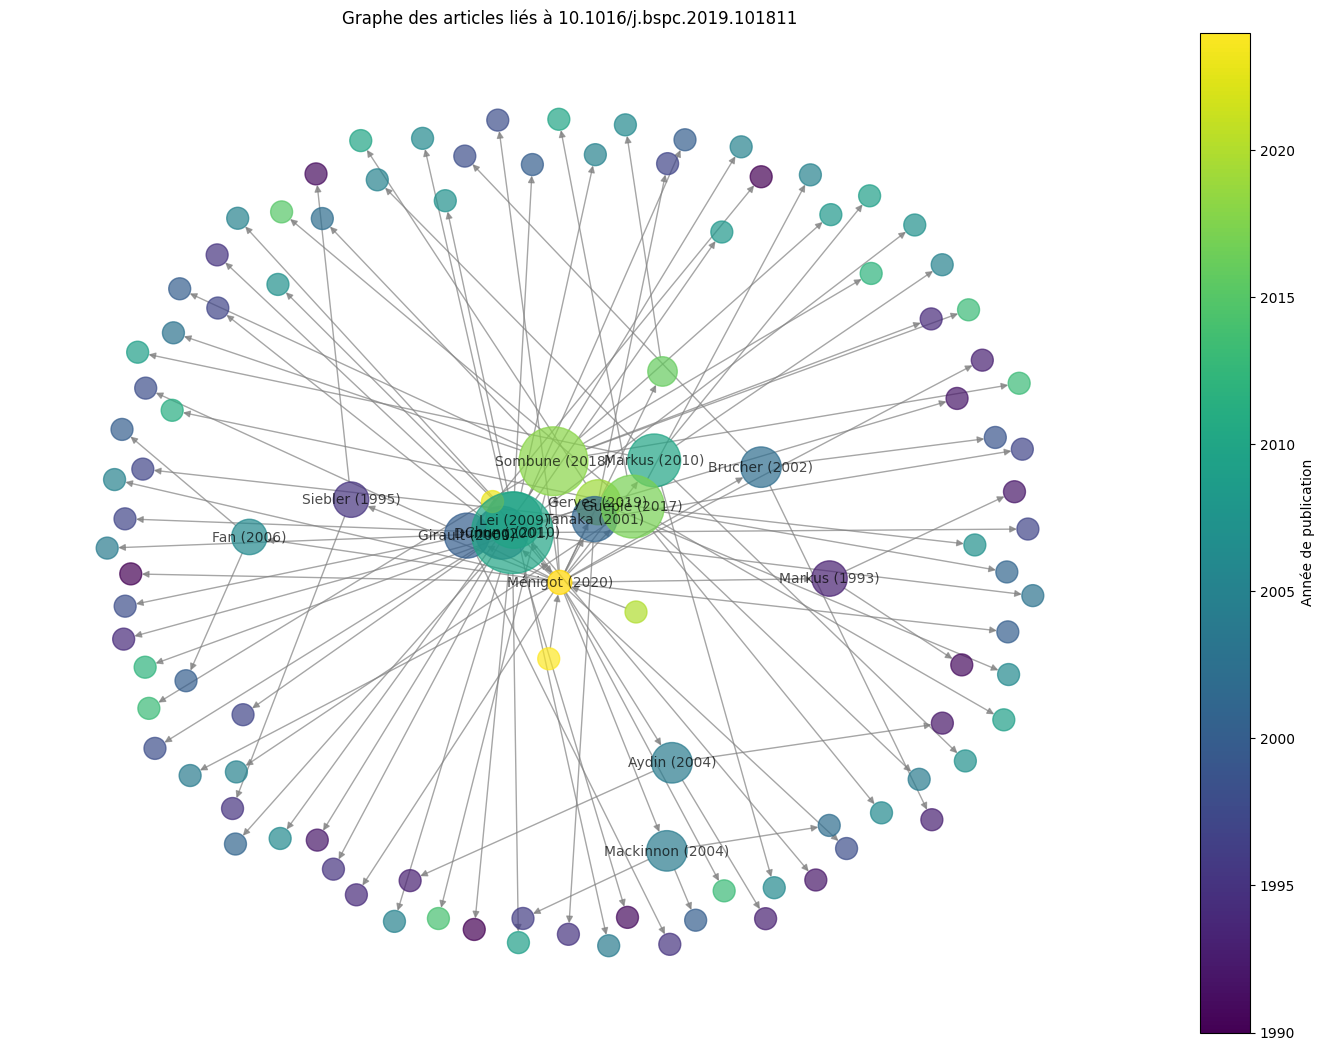

Print Graph OK
Les métadonnées avec connexions ont été enregistrées dans le fichier bibliography.bib
Save Data OK


In [8]:
import os

# Vérifier si un fichier de graphe existe déjà
graph_file = "graph.pkl"
reload_graph = False  # Passez à True si vous souhaitez recharger un graphe existant

if reload_graph and os.path.exists(graph_file):
    # Charger un graphe existant
    graph = load_graph(graph_file)
else:
    # Traiter l'article et construire le graphe
    graph = process_article(doi, depth=max_depth, min_year=min_year)
    # Sauvegarder le graphe
    save_graph(graph, graph_file)
print("Graph OK")

# Visualiser le graphe
visualize_graph(graph, doi, show_labels=True, min_year_graph=min_year)
print("Print Graph OK")

# Sauvegarder le graphe en BibTeX
save_bibtex(graph)
print("Save Data OK")
